# Tutorial 3
In this tutorial, we compare batched and unbatched optimizations.
Unbatched optimization can be very helpful when optimization large systems.

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
from metabox import modeling, assembly
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the metamodel we created in tutorial 1.
metamodel = modeling.load_metamodel("TiO2_square_metamodel", './example_folder')
metamodel.set_feature_constraint("pillar_width", vmin=10e-9, vmax=330e-9)

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=100e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=200e-6,             # the distance to the next surface
    metamodel=metamodel,          # the metamodel to use
    enable_propagator_cache=False, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=np.linspace(0.4e-6, 0.6e-6, 2), # 11 wavelengths between 400 and 800 nm
    phi=[0, 5],             # normal incidence
    theta=[0, 5],           # normal incidence
)

# Create a lens assembly.
batched_lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,   # Define the incidence.
        figure_of_merit=assembly.FigureOfMerit.LOG_STREHL_RATIO, # Define the figure of merit.
        use_padding=True,
)

# Create a reference lens assembly for comparison.
unoptimized_lens_assembly = batched_lens_assembly.copy()

For an unbatched assembly, the incidence contains multiple wavelengths and angles.

In [19]:
print(batched_lens_assembly.incidence)

Incidence(wavelength=array([4.e-07, 6.e-07]), theta=[0, 5], phi=[0, 5], jones_vector=(1, 0))


In [20]:
# Use the Adam optimizer to optimize the lens assembly.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)
# Optimize the lens assembly.
history = assembly.optimize_single_lens_assembly(
    batched_lens_assembly, 
    optimizer, 
    n_iter=40,
    verbose=1,
)

Bar desc:   0%|          | 0/40 [00:00<?, ?it/s]

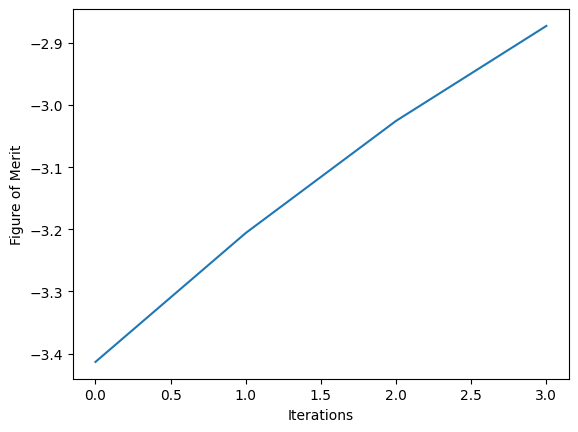

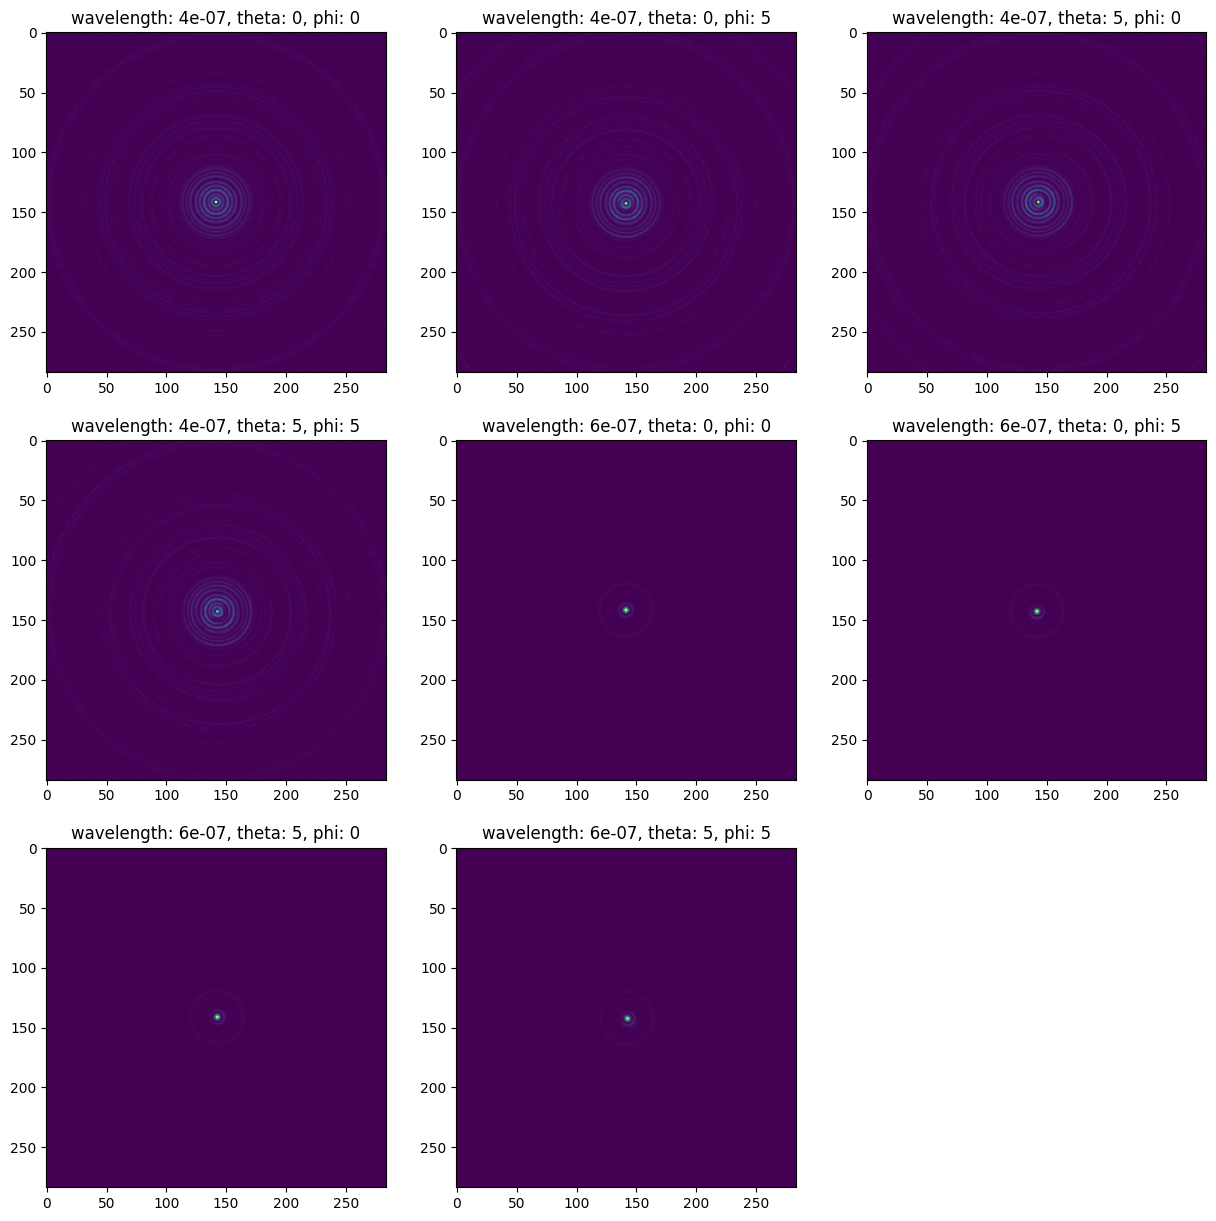

In [8]:
import itertools

# Plot the history of the figure of merit.
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Figure of Merit")
plt.show()

plt.figure(figsize=(15, 15))
intensity = batched_lens_assembly.compute_field_on_sensor().get_intensity()
for i, j, k in itertools.product(range(2), range(2), range(2)):
    wavelength = batched_lens_assembly.incidence.wavelength[i]
    theta = batched_lens_assembly.incidence.theta[j]
    phi = batched_lens_assembly.incidence.phi[k]
    plt.subplot(3, 3, i * 4 + j * 2 + k + 1)
    plt.imshow(intensity[i, j * 2 + k, :, :])
    plt.title(f"wavelength: {wavelength}, theta: {theta}, phi: {phi}")

Here, we create a list of assemblies with the same surfaces and figures of merit from the batched assembly. This way, the total memory usage should be reduced by P times, where P is the total permutations of the wavelengths and incident angles.
For a batched assembly, the incidence for each assembly contains only one wavelength and angle.

In [9]:
unbatched_assemblies = assembly.unbatch_lens_assembley(unoptimized_lens_assembly)
for lens_assembly in unbatched_assemblies:
    print(lens_assembly.incidence)

Incidence(wavelength=[4e-07], theta=[0], phi=[0], jones_vector=(1, 0))
Incidence(wavelength=[4e-07], theta=[0], phi=[5], jones_vector=(1, 0))
Incidence(wavelength=[4e-07], theta=[5], phi=[0], jones_vector=(1, 0))
Incidence(wavelength=[4e-07], theta=[5], phi=[5], jones_vector=(1, 0))
Incidence(wavelength=[6e-07], theta=[0], phi=[0], jones_vector=(1, 0))
Incidence(wavelength=[6e-07], theta=[0], phi=[5], jones_vector=(1, 0))
Incidence(wavelength=[6e-07], theta=[5], phi=[0], jones_vector=(1, 0))
Incidence(wavelength=[6e-07], theta=[5], phi=[5], jones_vector=(1, 0))


Here, we optimize the unbatched instannes the 

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)
history = assembly.optimize_multiple_lens_assemblies(
    unbatched_assemblies, 
    optimizer, 
    n_iter=40, 
    verbose=1
)

Loss: 0.980344: 100%|██████████| 40/40 [03:12<00:00,  4.82s/it]


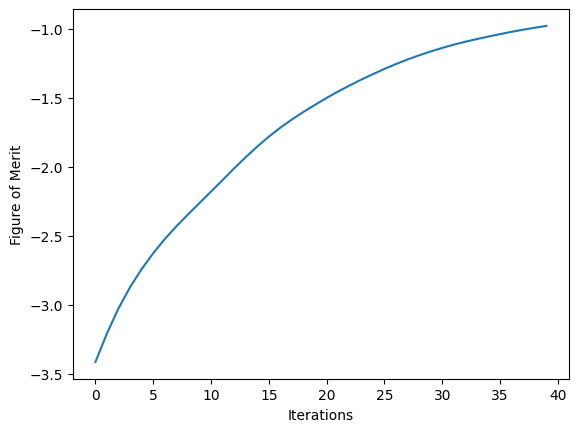

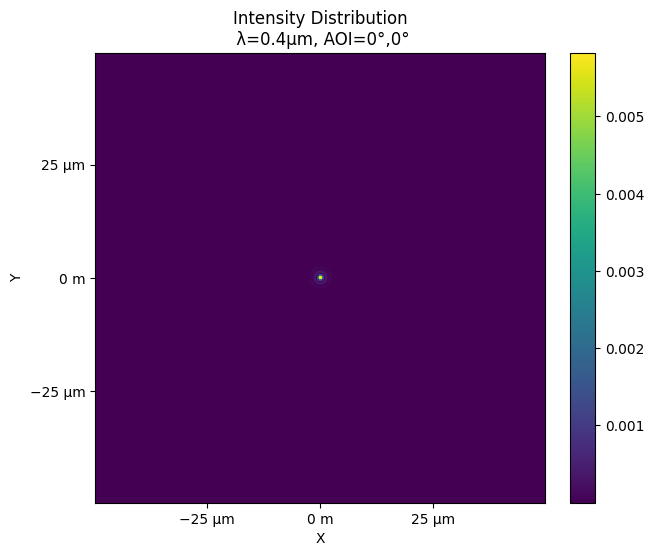

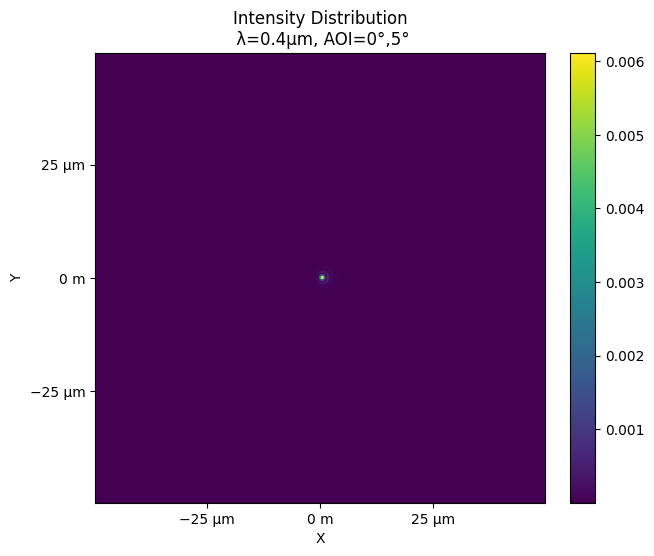

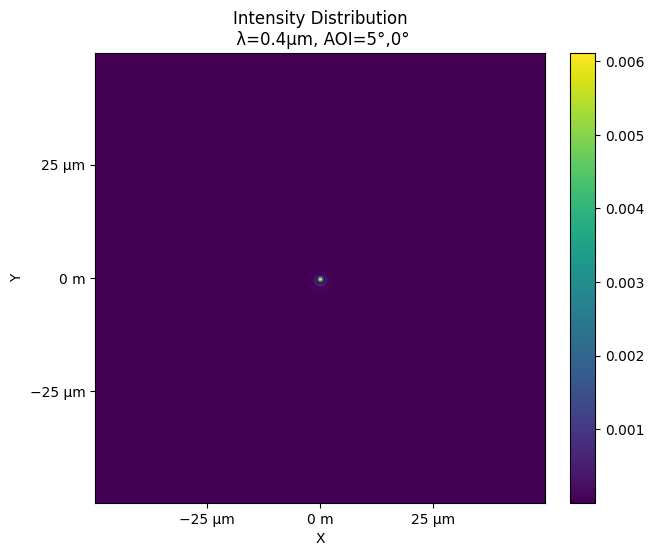

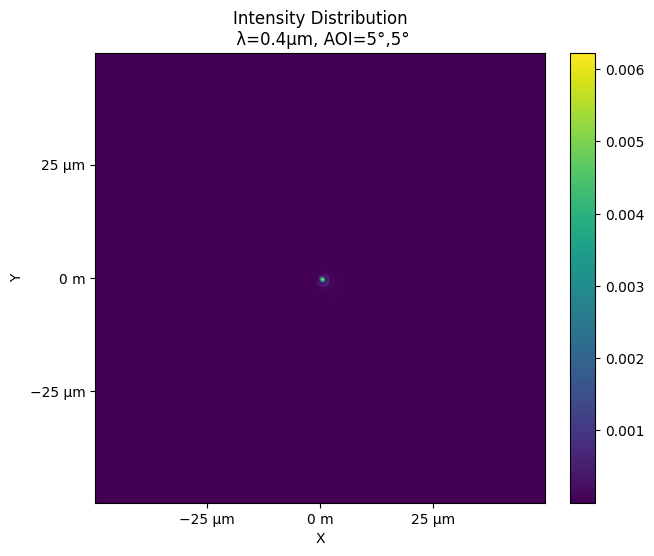

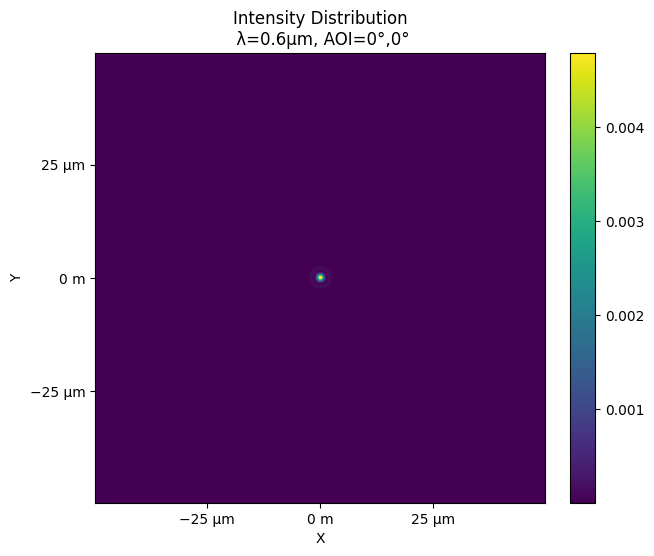

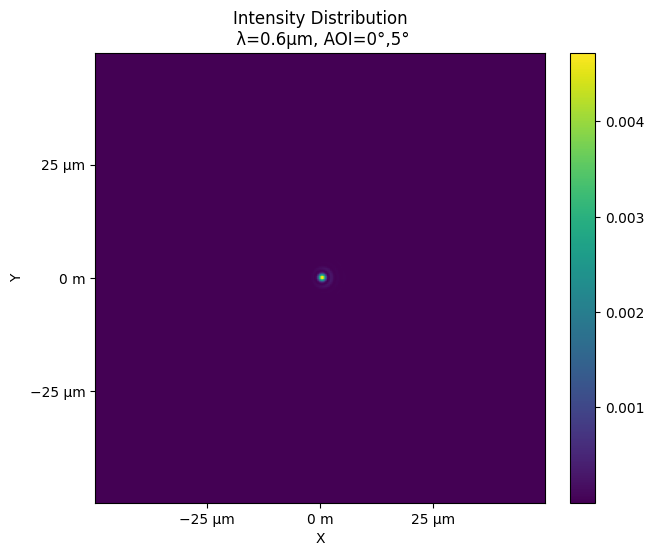

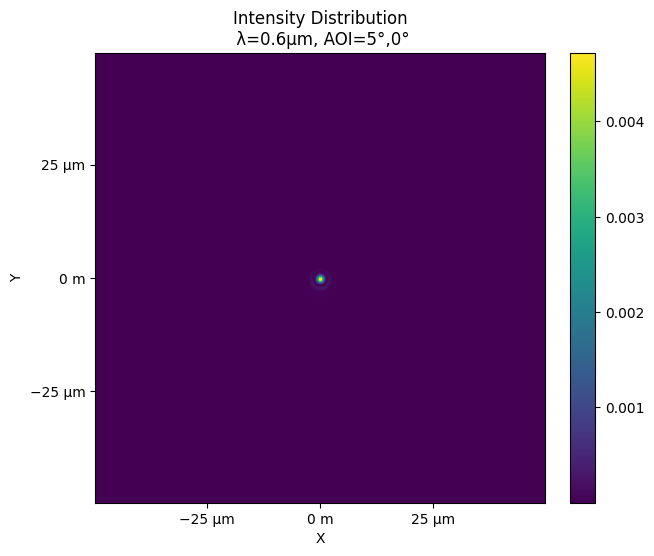

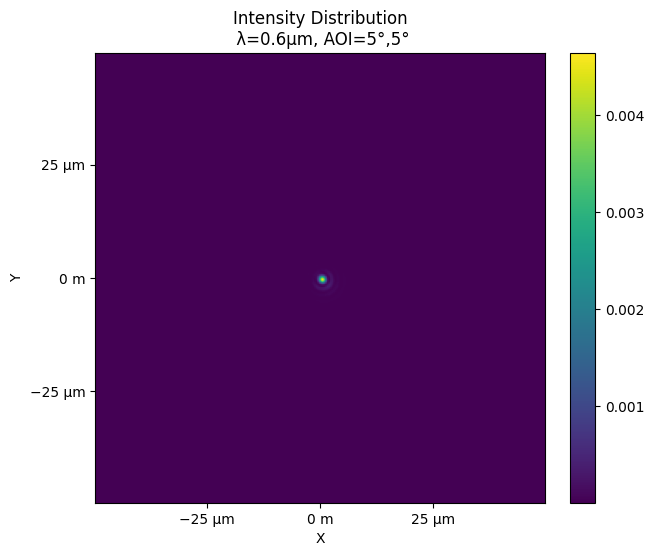

In [15]:
# Plot the history of the figure of merit.
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Figure of Merit")
plt.show()

for (i, lens_assembly) in enumerate(unbatched_assemblies):
    unbatched_assemblies[i].show_psf()

In [16]:
# Compare the structures in each assembly are the same.
all_structures = []
for lens_assembly in unbatched_assemblies:
    st = lens_assembly.surfaces[0].atom_1d.tensor.numpy()
    all_structures.append(st)
for i in range(len(all_structures) - 1):
    assert np.all(all_structures[i] == all_structures[i+1])